In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
%matplotlib inline

#read in chessboard images
file_name = 'camera_cal/calibration{}.jpg'.format(2)
img = cv2.imread(file_name)

In [2]:
def find_corners(img):
    # prepare object points
    nx = 9 # Inside corners on x-axis
    ny = 6 # Inside corners on y-axis

    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(img, (nx, ny), None)
    return ret, corners, img, nx, ny

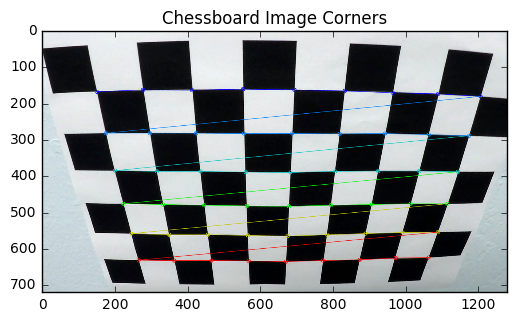

In [3]:
ret, corners, img, nx, ny = find_corners(img)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.title("Chessboard Image Corners")
    plt.show()

In [4]:
def compute_calibration(img, nx, ny):
    img_shape = (img.shape[1], img.shape[0])
    #compute calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape,None,None)    
    return ret, mtx, dist, rvecs, tvecs

In [5]:
def correct_distortion(img, mtx, dist):    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [6]:
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):

    # Apply cv2.Sobel()
    #Calculate the derivative in the x-direction (the 1, 0 at the end denotes x-direction)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    #Calculate the derivative in the x-direction (the 1, 0 at the end denotes y-direction)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    #Calculate the absolute value of the x-derivative
    abs_sobelx = np.absolute(sobelx)
    # Take the absolute value of the output from cv2.Sobel()
    # Scale the result to an 8-bit range (0-255)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Apply lower and upper thresholds
    # Create binary_output
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

# Find the magnitude of the gradient for a given sobel kernel size and threshold values
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

#Threshold the image for a given range and Sobel kernel
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def combine_sobel(gray):
    ksize = 7
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', thresh_min=10, thresh_max=255)
    grady = abs_sobel_thresh(gray, orient='y', thresh_min=60, thresh_max=255)
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
    # Combine all the thresholding information
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

# Function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

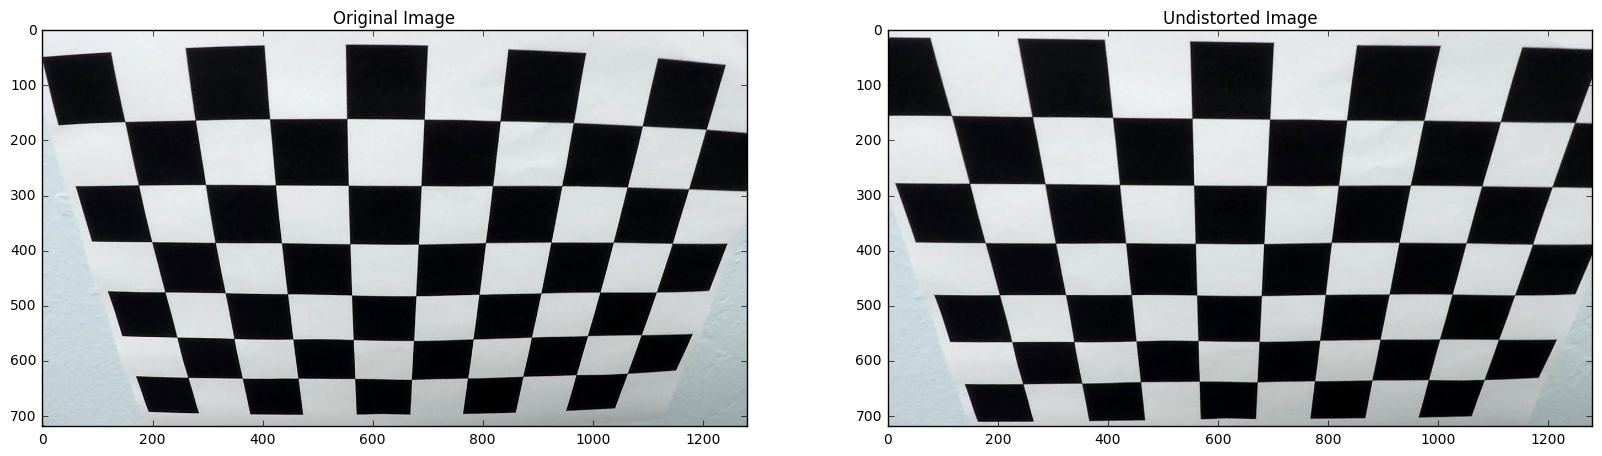

In [7]:
#calculate the camera matrix and distortion coefficients using the calibration chessboard images 
# prepare object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = []

# Loop through images in the image directory
for i in range(1,3):
    file_name = 'camera_cal/calibration{}.jpg'.format(i)
    img = cv2.imread(file_name)
    ret, corners, img, nx, ny = find_corners(img)
    # If found, add object and image points, draw corners
    if ret == True:
        #print(file_name)
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)
        #plt.title("Chessboard Image Corners")
        #plt.show()
        
        ret, mtx, dist, rvecs, tvecs = compute_calibration(img, nx, ny)
        undistorted_img = correct_distortion(img, mtx, dist)
        # Visualize undistortion comparism
        f, (org_img, undst_img) = plt.subplots(1, 2, figsize=(20,10))
        org_img.imshow(img)
        org_img.set_title('Original Image')
        undst_img.imshow(undistorted_img)
        undst_img.set_title('Undistorted Image')       
    

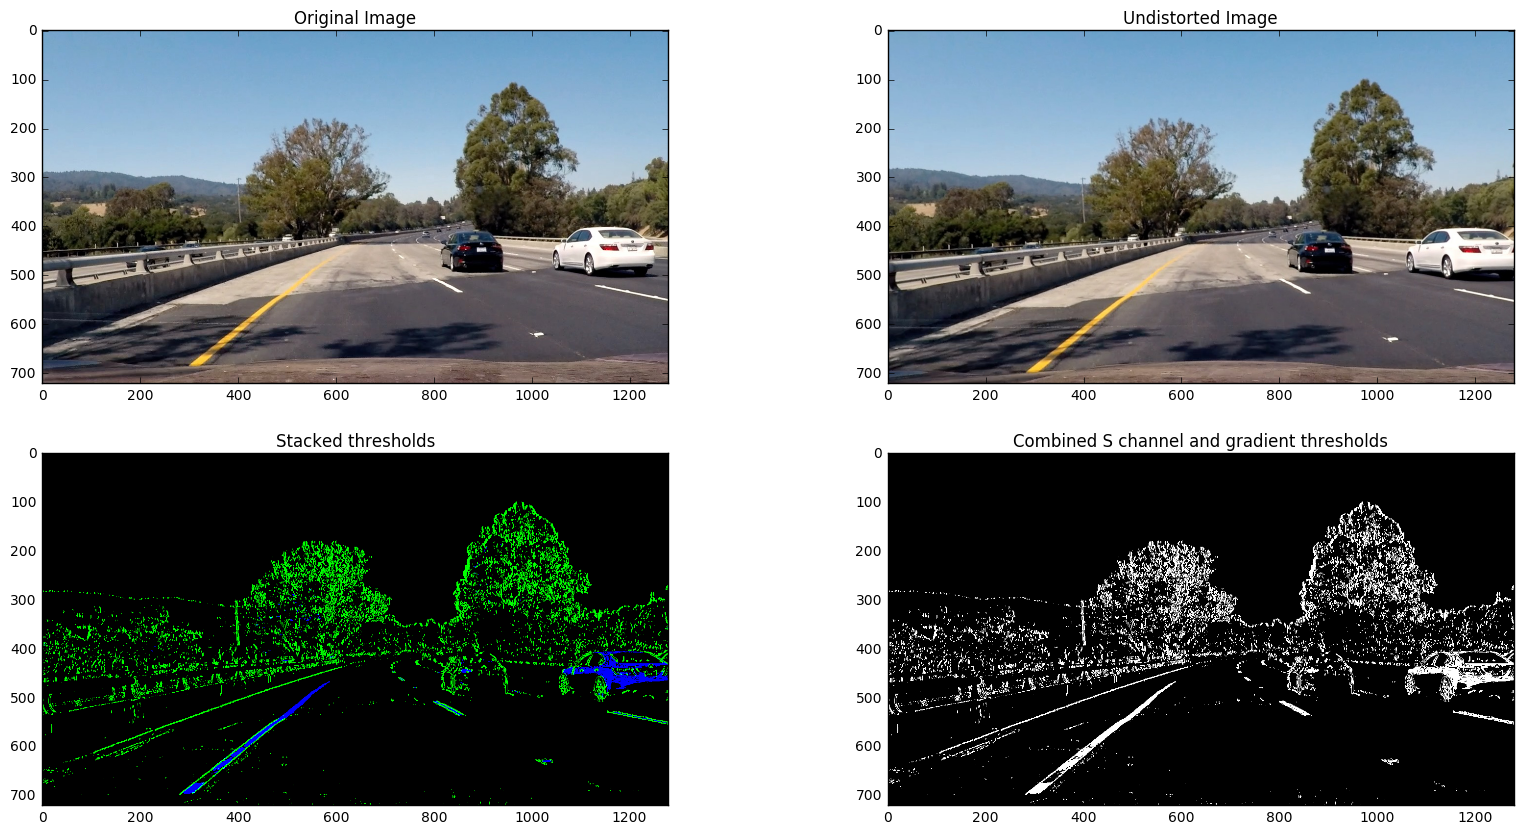

In [19]:
test_file = 'test_images/test4.jpg'
#test_img = cv2.imread(test_file)
test_img = mpimg.imread(test_file)
ret, corners, img, nx, ny = find_corners(test_img)
ret, mtx, dist, rvecs, tvecs = compute_calibration(img, nx, ny)

undistorted_im = correct_distortion(img, mtx, dist)

def create_binary_image(img, s_thresh=(170, 255), sx_thresh=(20, 100),  l_thresh = (30, 255)):
        
    # Convert undistorted image to HLS color space 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    
    # Threshold color channel saturation and lightness channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) 
             & (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # Stack each channel of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary

color_binary, combined_binary = create_binary_image(undistorted_im)

# Plot the orig and result    
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10)) 
    
ax1.imshow(test_img)
ax1.set_title('Original Image')
 
ax2.imshow(undistorted_im)
ax2.set_title('Undistorted Image')

ax3.imshow(color_binary)   
ax3.set_title('Stacked thresholds')

ax4.imshow(combined_binary, cmap='gray')
ax4.set_title('Combined S channel and gradient thresholds')

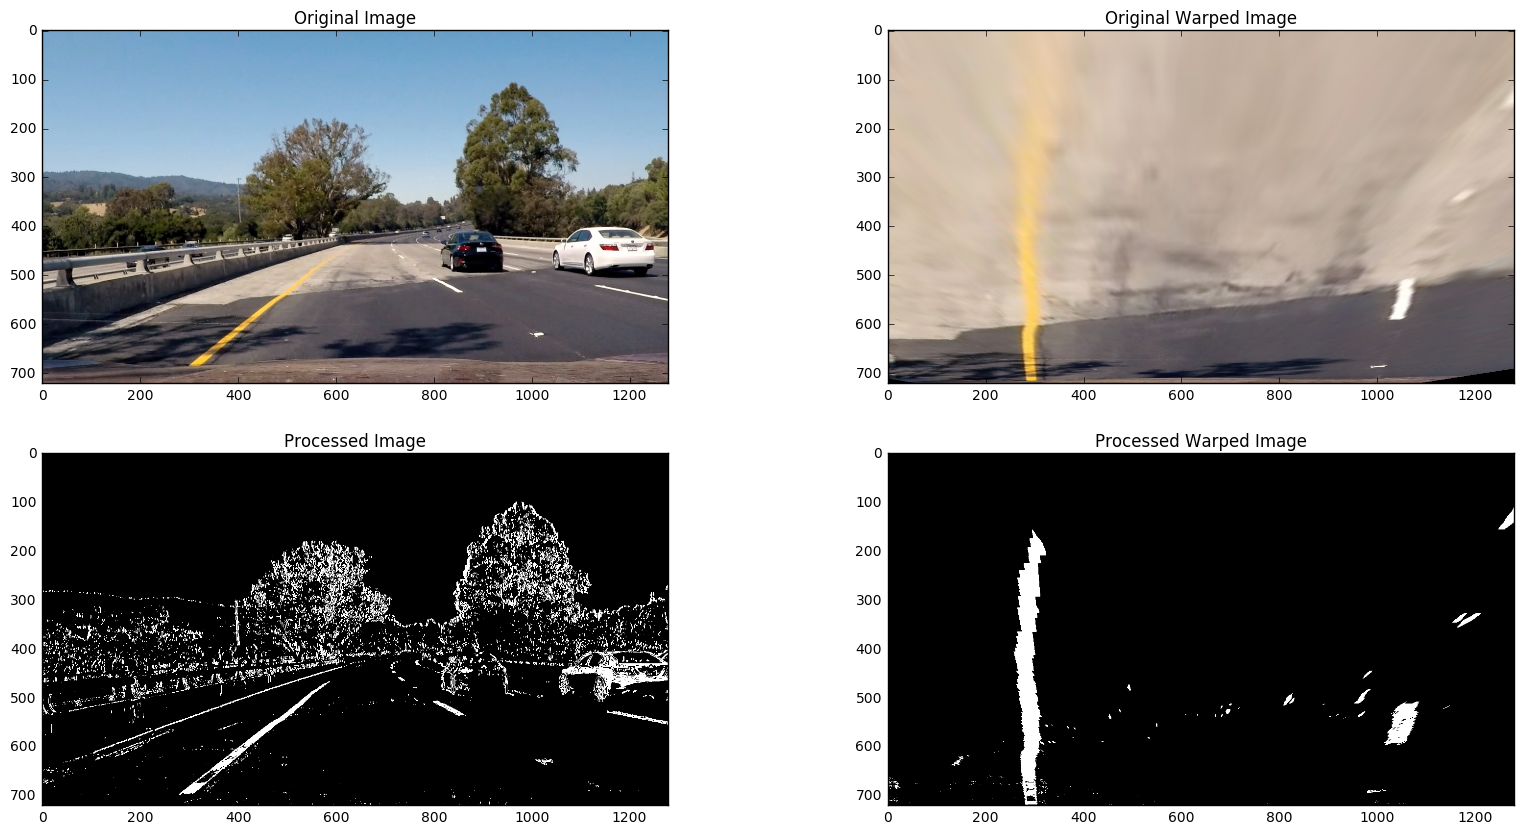

In [20]:
def warp_perspective_transform (img):
    offset = 300
    img_size = (img.shape[1], img.shape[0])

    src = np.float32([[595,460],[680, 460],[1150, 700],[300,700]])
    dst = np.float32([[offset, 0], [img_size[0]-offset,0],[img_size[0]-offset, img_size[1]], [offset,img_size[1]]])   
    M = cv2.getPerspectiveTransform(src,dst)
    
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    
    return warped

warp_image = warp_perspective_transform(combined_binary)
orig_warp_image = warp_perspective_transform(img)

# Plot the result
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10)) 
    
ax1.imshow(img)
ax1.set_title('Original Image')
 
ax2.imshow(orig_warp_image)
ax2.set_title('Original Warped Image')

ax3.imshow(combined_binary, cmap='gray')   
ax3.set_title('Processed Image')

ax4.imshow(warp_image, cmap='gray')
ax4.set_title('Processed Warped Image')

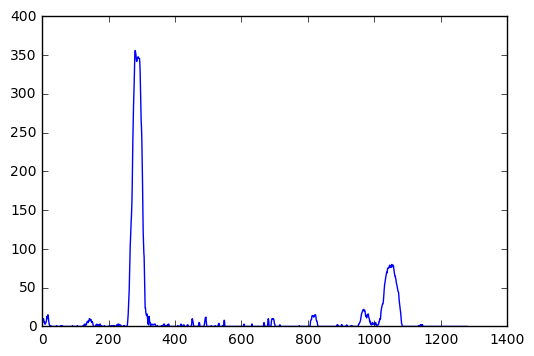

In [21]:
# histogram along all the columns in the lower half of the image
histogram = np.sum(warp_image[int(warp_image.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [11]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warp_image, warp_image, warp_image))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warp_image.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warp_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warp_image.shape[0] - (window+1)*window_height
    win_y_high = warp_image.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

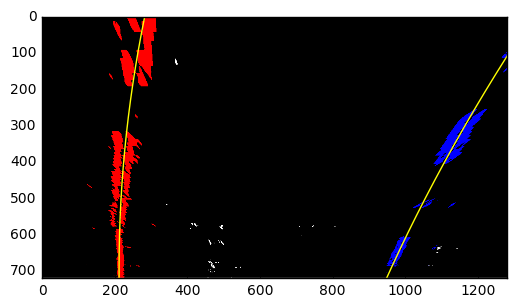

In [22]:
# Generate x and y values for plotting
ploty = np.linspace(0, warp_image.shape[0]-1, warp_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [13]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "warp_image")
# It's now much easier to find line pixels!
nonzero = warp_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, warp_image.shape[0]-1, warp_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

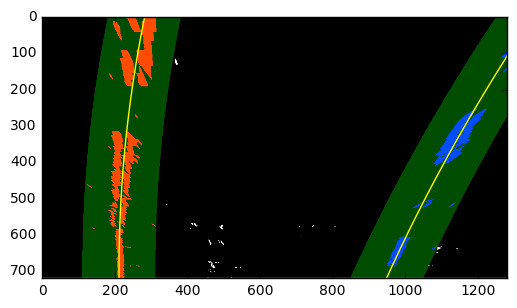

In [14]:
out_img = np.dstack((warp_image, warp_image, warp_image))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [15]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [16]:
#estimate the radius of curvature of the road and position vehicle wrt center lane
def find_lane_curvature(leftx, lefty, rightx, righty, y_eval, image_mid_point):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.7 / 82  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 790  # meters per pixel in x dimension
    left_lane_fit = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_lane_fit = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    left_curvature = ((1 + (2 * left_lane_fit[0] * y_eval * ym_per_pix + left_lane_fit[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_lane_fit[0])
    right_curvature = ((1 + (2 * right_lane_fit[0] * y_eval * ym_per_pix + right_lane_fit[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_lane_fit[0])
    # calculate the x position for y at the height of the image for left lane
    left_lane_bottom = left_lane_fit[0] * (y_eval * ym_per_pix) ** 2 + left_lane_fit[1] * (y_eval * ym_per_pix) + \
                       left_lane_fit[2]
    # calculate the x position for y at the height of the image for right lane
    right_lane_bottom = right_lane_fit[0] * (y_eval * ym_per_pix) ** 2 + right_lane_fit[1] * (y_eval * ym_per_pix) + \
                        right_lane_fit[2]

    # calculate the mid point of identified lane
    lane_midpoint = float(right_lane_bottom - left_lane_bottom) / 2

    lane_deviation = 0.0;
    # Convert image center to meters 
    image_mid_point_meters = image_mid_point * xm_per_pix;

    lane_deviation = (image_mid_point_meters - lane_midpoint) * 100;
    return left_curvature, right_curvature, lane_deviation

#find lane lines pixels in warped image using a sliding window
def sliding_window_line_fit(warp_image):
    histogram = np.sum(warp_image[int(warp_image.shape[0]/2):,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    image_mid_point = warp_image.shape[1]/2
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    left_inside = midpoint - leftx_base + 200;#
    rightx_inside = rightx_base - midpoint;#

    # Choose the number of sliding windows
    nwindows = 4
    # Set height of windows
    window_height = np.int(warp_image.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warp_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warp_image.shape[0] - (window + 1) * window_height
        win_y_high = warp_image.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
            nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
            nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values 
    ploty = np.linspace(300, warp_image.shape[0]-1, warp_image.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #increase the image size helps to extrapolate points to the bottom of screen.
    window_img = np.zeros((warp_image.shape[0], warp_image.shape[1], 3), np.uint8)

    #to place the identified lane line accurately on the top of lane. -20 is needed since
    margin_edge = 20;

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin_edge, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + left_inside, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - rightx_inside, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx -margin_edge, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draws the lane onto the warped blank image. 
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))

    # Draws the lane line in blue color
    cv2.polylines(window_img, np.int_([left_line_window1]), False, color=(255, 0, 0), thickness=20)
    cv2.polylines(window_img, np.int_([right_line_window2]), False, color=(255, 0, 0), thickness=20)

    y_eval = np.max(ploty)

    left_curvature, right_curvature, lane_deviation = find_lane_curvature(leftx, lefty, rightx, righty, y_eval, image_mid_point)
    return window_img, left_curvature, right_curvature, lane_deviation

#unwarp back found lanes to the original image space and annotate lane curvature and deviation
def unwarp_perspective_n_annotate(undistorted_im, result, left_curvature, right_curvature, lane_deviation, Minv):
    #Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(undistorted_im, 'Right Curvature :' + str(round(right_curvature,2)) + 'm', (20, 50), font, 1, (255, 255, 255), 2)
    cv2.putText(undistorted_im, 'Left Curvature :' + str(round(left_curvature,2)) + 'm', (20, 100), font, 1, (255, 255, 255), 2)
    cv2.putText(undistorted_im, 'Lane Deviation :' +  str(round(lane_deviation,2)) + 'cm', (20, 160), font, 1, (255, 255, 255), 2)
    unwarp = cv2.warpPerspective(result, Minv, (result.shape[1], result.shape[0]))
    
    # Transform perspective of result back to the original image space
    unwarped_img = cv2.resize(unwarp, (undistorted_im.shape[1], undistorted_im.shape[0]))    
    return cv2.addWeighted(undistorted_im, 1, unwarped_img, 0.6, 0)

In [17]:
# create pipeline to process each frame of video
def process_frames(img):
    offset = 300
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[595,460],[680, 460],[1150, 700],[300,700]])
    dst = np.float32([[offset, 0], [img_size[0]-offset,0],[img_size[0]-offset, img_size[1]], [offset,img_size[1]]])   
    Minv =  cv2.getPerspectiveTransform(dst,src)
    
    ret, corners, img, nx, ny = find_corners(img)
    ret, mtx, dist, rvecs, tvecs = compute_calibration(img, nx, ny)
    
    # apply distortion correction to each image
    undistorted_im = correct_distortion(img, mtx, dist)
    
    #create binary image using color transforms, Combined S channel and gradient thresholds
    color_binary, combined_binary = create_binary_image(undistorted_im)
    
    #apply perspective transform to binary image - warp the image
    warp_image = warp_perspective_transform(combined_binary)
    
    #find lane lines pixels in warped image and fit with a polynomial
    #estimate the radius of curvature of the road and position vehicle wrt center lane
    result, left_curvature, right_curvature, lane_deviation = sliding_window_line_fit(warp_image) 
    
    #unwarp back found lanes to the original image space and annotate lane curvature and deviation
    return unwarp_perspective_n_annotate(undistorted_im, result, left_curvature, right_curvature, lane_deviation, Minv)

In [18]:
# Run algorithm on project video

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_output.mp4'
input_video = VideoFileClip("project_video.mp4")
process_video = lambda x: process_frames(x)
output_clip = input_video.fl_image(process_video) 
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [17:51<00:00,  1.20it/s]  0%|                                         | 1/1261 [00:01<24:41,  1.18s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 17min 53s
